# Notebook Revisi FP Data Mining Kelompok 19

## Anggota
1. Pranandha Dhaiva Dhaniswara - 5025231260
2. Raihan Albar Wijaya - 5025231227
3. Royyan Abror Zainardi - 5025231223

In [1]:
!pip install pandas numpy scikit-learn xgboost catboost shap tensorflow ctgan

In [2]:
import pandas as pd
import numpy as np
import shap
import warnings
import os
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import wasserstein_distance
from IPython.display import display

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Machine Learning Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Preprocessing & Metrics
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Data Augmentation
try:
    from ctgan import CTGAN, TVAE
except ImportError:
    raise ImportError("Please install ctgan: pip install ctgan")

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

print("Setup Complete. All Libraries Imported.")

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Setup Complete. All Libraries Imported.


In [3]:
# === PHASE 1: LOAD DATASET ===

print("[Phase 1] Loading Data...", flush=True)
df = pd.read_csv('AmesHousing.csv')
print("    Loaded from local runtime.")

[Phase 1] Loading Data...
    Loaded from local runtime.


[Phase 2] Running Comprehensive EDA...

--- 1.1 Dataset Structure ---
Shape: (2930, 82)

--- 1.2 Column Types ---
object     43
int64      28
float64    11
Name: count, dtype: int64

--- 1.3 Missing Value Analysis ---
Columns with missing values: 27
                Missing Count Percent
Pool QC                  2917  99.56%
Misc Feature             2824  96.38%
Alley                    2732  93.24%
Fence                    2358  80.48%
Mas Vnr Type             1775  60.58%
Fireplace Qu             1422  48.53%
Lot Frontage              490  16.72%
Garage Qual               159   5.43%
Garage Cond               159   5.43%
Garage Yr Blt             159   5.43%
Garage Finish             159   5.43%
Garage Type               157   5.36%
Bsmt Exposure              83   2.83%
BsmtFin Type 2             81   2.76%
Bsmt Cond                  80   2.73%

--- 1.4 Duplicate Check ---
Duplicate Rows: 0

2. TARGET DISTRIBUTION ANALYSIS


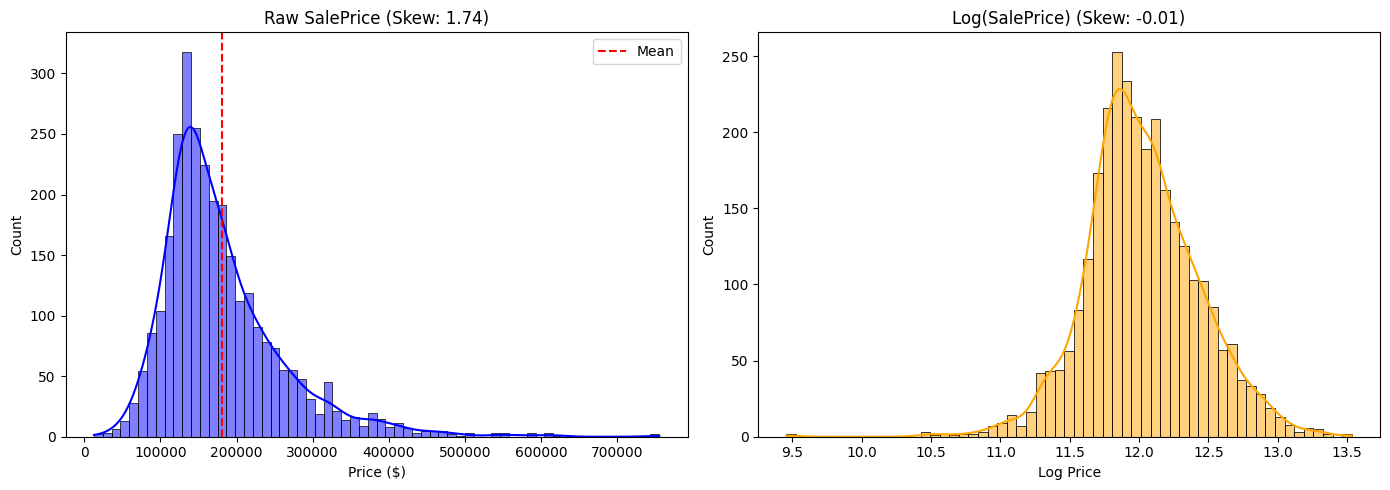


3. NUMERIC CORRELATIONS
Top 10 Features Correlated with SalePrice:
Overall Qual      0.799262
Gr Liv Area       0.706780
Garage Cars       0.647877
Garage Area       0.640401
Total Bsmt SF     0.632280
1st Flr SF        0.621676
Year Built        0.558426
Full Bath         0.545604
Year Remod/Add    0.532974
Garage Yr Blt     0.526965
Name: SalePrice, dtype: float64


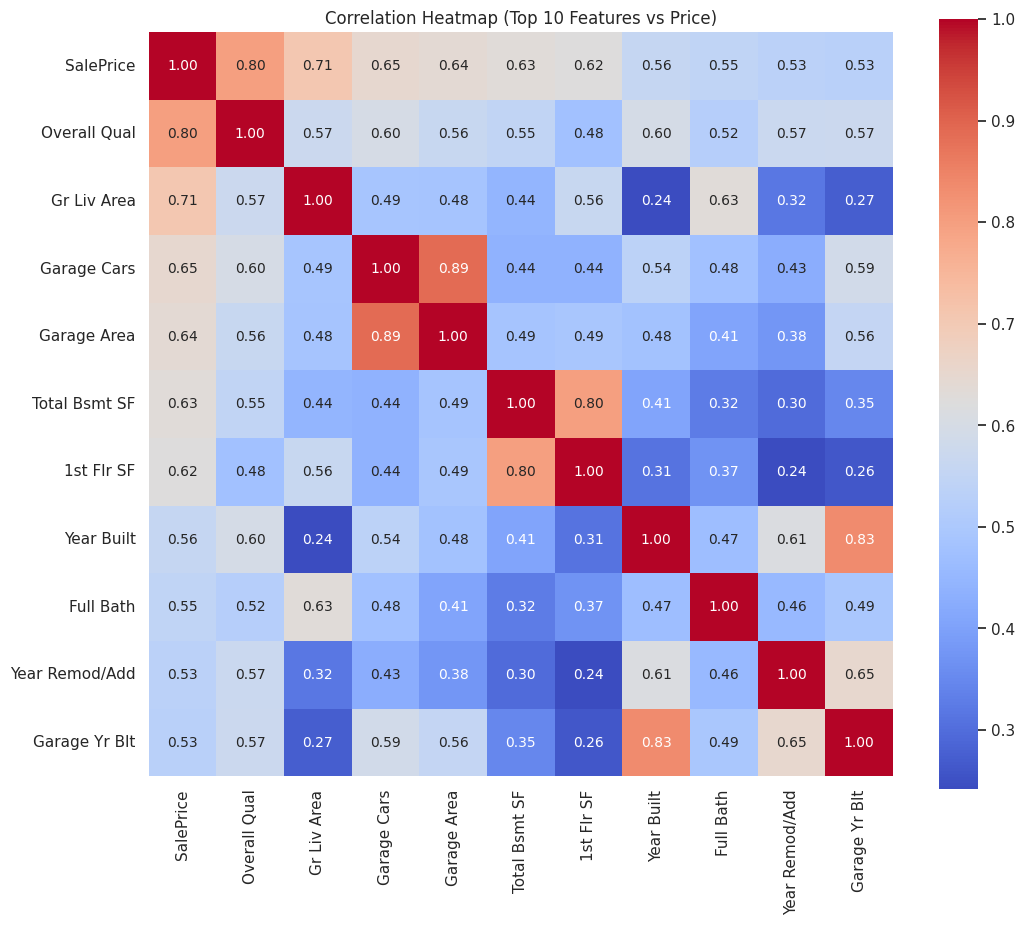


--- 4. Outlier Detection ---


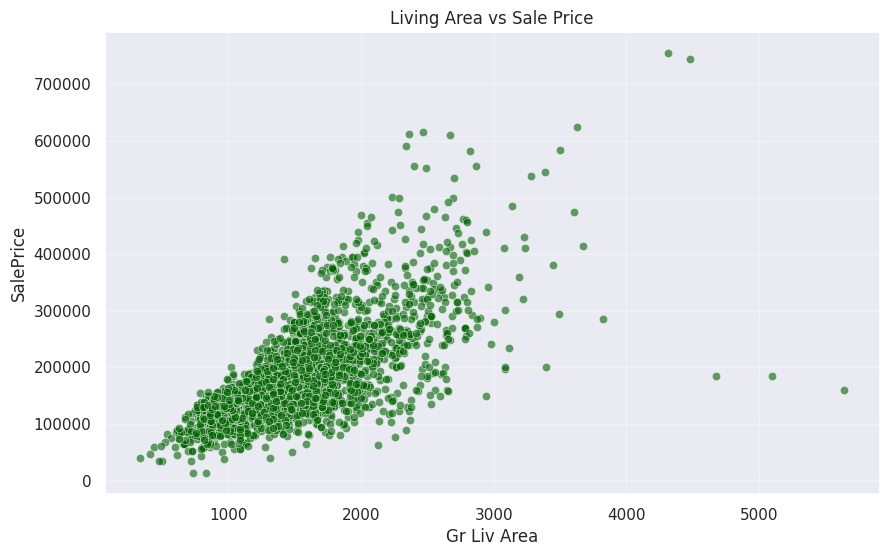


--- 5. ANOVA Analysis ---
Top 5 Categorical Features (F-Score):
Exter Qual           F-Score: 993.96
Bsmt Qual            F-Score: 724.16
Kitchen Qual         F-Score: 680.47
Garage Finish        F-Score: 520.89
Foundation           F-Score: 227.57


In [4]:
# === PHASE 2: COMPLETE EXPLORATORY DATA ANALYSIS (EDA) ===
print("[Phase 2] Running Comprehensive EDA...", flush=True)

# 1. Dataset Information
def print_detailed_info(df):
    print("\n--- 1.1 Dataset Structure ---")
    print(f"Shape: {df.shape}")

    print("\n--- 1.2 Column Types ---")
    print(df.dtypes.value_counts())

    print("\n--- 1.3 Missing Value Analysis ---")
    null_counts = df.isnull().sum()
    null_pct = (df.isnull().sum() / len(df)) * 100
    missing_data = pd.DataFrame({
        'Missing Count': null_counts,
        'Percent': null_pct
    })
    missing_data = missing_data[missing_data['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)

    # Format percentages for display
    missing_data['Percent'] = missing_data['Percent'].map('{:.2f}%'.format)

    if not missing_data.empty:
        print(f"Columns with missing values: {len(missing_data)}")
        print(missing_data.head(15).to_string()) # Show top 15
    else:
        print("No missing values found.")

    print("\n--- 1.4 Duplicate Check ---")
    print(f"Duplicate Rows: {df.duplicated().sum()}")

print_detailed_info(df)

# 2. Target Distribution
print("\n" + "="*40)
print("2. TARGET DISTRIBUTION ANALYSIS")
print("="*40)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw Distribution
sns.histplot(df['SalePrice'], kde=True, ax=axes[0], color='blue')
axes[0].set_title(f"Raw SalePrice (Skew: {df['SalePrice'].skew():.2f})")
axes[0].set_xlabel("Price ($)")
axes[0].axvline(df['SalePrice'].mean(), color='red', linestyle='--', label='Mean')
axes[0].legend()

# Log-Transformed Distribution
# We check this because regression models often prefer normal distributions
sns.histplot(np.log1p(df['SalePrice']), kde=True, ax=axes[1], color='orange')
axes[1].set_title(f"Log(SalePrice) (Skew: {np.log1p(df['SalePrice']).skew():.2f})")
axes[1].set_xlabel("Log Price")

plt.tight_layout()
plt.show()

# 3. Correlation Heatmap
print("\n" + "="*40)
print("3. NUMERIC CORRELATIONS")
print("="*40)

# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])
# Drop ID columns if they exist as they are not useful features
numeric_df = numeric_df.drop(columns=['Order', 'PID', 'Id'], errors='ignore')

# Calculate correlation matrix
corr_matrix = numeric_df.corr()

# Get Top 10 Features correlated with Price
k = 11 # Number of variables for heatmap (10 features + SalePrice)
cols = corr_matrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = df[cols].corr()

print("Top 10 Features Correlated with SalePrice:")
print(corr_matrix['SalePrice'].sort_values(ascending=False).head(11).iloc[1:]) # Skip SalePrice itself

# Plot Heatmap
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.0)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
            annot_kws={'size': 10}, yticklabels=cols.values,
            xticklabels=cols.values, cmap='coolwarm')
plt.title('Correlation Heatmap (Top 10 Features vs Price)')
plt.show()

# 4. Outlier Detection
print("\n--- 4. Outlier Detection ---")
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Gr Liv Area', y='SalePrice', data=df, alpha=0.6, color='darkgreen')
plt.title('Living Area vs Sale Price')
plt.grid(True, alpha=0.3)
plt.show()

# 5. ANOVA
print("\n--- 5. ANOVA Analysis ---")
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
significant_cats = []
for col in cat_cols:
    valid_data = df.dropna(subset=[col, 'SalePrice'])
    groups = [valid_data[valid_data[col] == c]['SalePrice'].values for c in valid_data[col].unique()]
    if len(groups) > 1:
        try:
            f_stat, p_val = stats.f_oneway(*groups)
            if p_val < 0.05: significant_cats.append((col, f_stat))
        except: pass
significant_cats.sort(key=lambda x: x[1], reverse=True)
print("Top 5 Categorical Features (F-Score):")
for name, score in significant_cats[:5]: print(f"{name:<20} F-Score: {score:.2f}")

[Phase 3] Preprocessing...
    Running SHAP Selection on new features...
    Top 3 Features: ['TotalSF', 'Overall Qual', 'Kitchen Qual']

    Generating SHAP Plots...


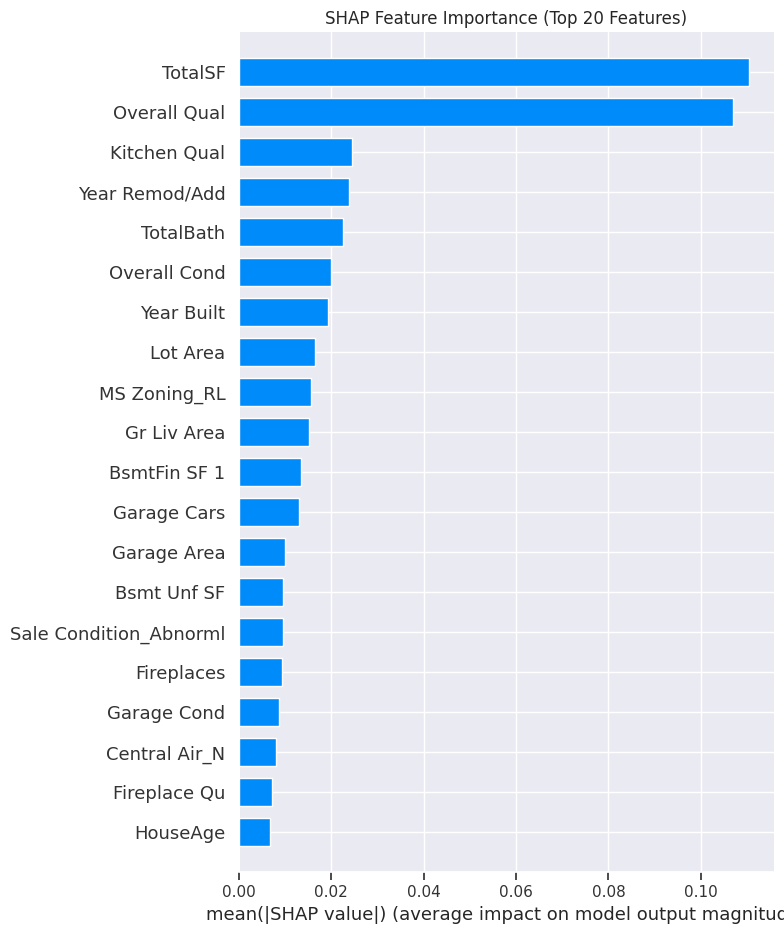

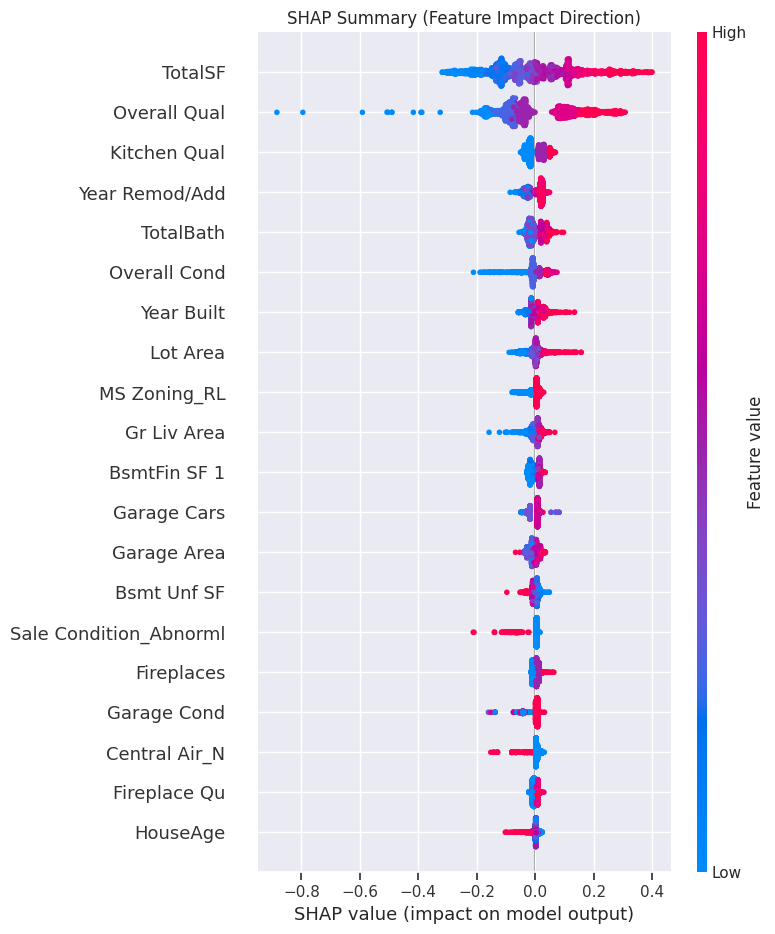

    Phase 3 Complete. Train Shape: (2340, 273)


In [5]:
# === PHASE 3: PREPROCESSING ===
print("[Phase 3] Preprocessing...", flush=True)

# 1. CLEANING & TARGET TRANSFORMATION
# Load fresh to ensure no index contamination
df_clean = pd.read_csv('AmesHousing.csv')

# A. Remove Outliers (Based on EDA) - Doing this BEFORE split ensures X and y stay aligned
# Gr Liv Area > 4000 is a standard recommended cut for Ames dataset
df_clean = df_clean[df_clean['Gr Liv Area'] < 4000].reset_index(drop=True)

# B. Separate Target and Log-Transform
# We use log1p to fix the 1.74 Skewness found in EDA
X = df_clean.drop(columns=['SalePrice', 'Order', 'PID', 'Id'], errors='ignore')
y = np.log1p(df_clean['SalePrice'])

# 2. SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. DOMAIN IMPUTATION
def impute_domain(df_in):
    df_out = df_in.copy()

    # Lot Frontage via Neighborhood Median
    if 'Lot Frontage' in df_out.columns and 'Neighborhood' in df_out.columns:
        df_out['Lot Frontage'] = df_out.groupby('Neighborhood')['Lot Frontage'] \
            .transform(lambda x: x.fillna(x.median()))
        df_out['Lot Frontage'] = df_out['Lot Frontage'].fillna(0) # Fallback

    # Fill None
    none_cols = ['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu',
                 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond',
                 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
                 'BsmtFin Type 2', 'Mas Vnr Type']
    for c in none_cols:
        if c in df_out.columns: df_out[c] = df_out[c].fillna("None")

    # Fill Zero
    zero_cols = ['Garage Area', 'Garage Cars', 'BsmtFin SF 1', 'BsmtFin SF 2',
                 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath',
                 'Mas Vnr Area', 'Garage Yr Blt']
    for c in zero_cols:
        if c in df_out.columns: df_out[c] = df_out[c].fillna(0)

    return df_out

X_train = impute_domain(X_train)
X_test = impute_domain(X_test)

# 4. FEATURE ENGINEERING
def engineer_features(df_in):
    df_out = df_in.copy()
    # Total SF
    df_out['TotalSF'] = df_out.get('Total Bsmt SF', 0) + df_out.get('1st Flr SF', 0) + df_out.get('2nd Flr SF', 0)
    # Total Bath
    df_out['TotalBath'] = df_out.get('Full Bath', 0) + 0.5*df_out.get('Half Bath', 0) + df_out.get('Bsmt Full Bath', 0)
    # House Age
    if 'Yr Sold' in df_out.columns and 'Year Built' in df_out.columns:
        df_out['HouseAge'] = df_out['Yr Sold'] - df_out['Year Built']
    # Polynomial (Quality is non-linear)
    if 'Overall Qual' in df_out.columns:
        df_out['OverallQual_Sq'] = df_out['Overall Qual'] ** 2

    return df_out

X_train = engineer_features(X_train)
X_test = engineer_features(X_test)

# 5. ENCODING
# A. Manual Ordinal (Preserve Rank)
qual_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
ordinal_cols = ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
                'Heating QC', 'Kitchen Qual', 'Fireplace Qu',
                'Garage Qual', 'Garage Cond', 'Pool QC']

for col in ordinal_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].map(qual_map).fillna(0)
        X_test[col] = X_test[col].map(qual_map).fillna(0)

# B. Pipeline for Remaining (Numeric & Nominal)
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ]), cat_cols)
], verbose_feature_names_out=False)

# Apply Transformation
X_train_sk1 = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out())
X_test_sk1 = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())

# Ensure Indices match y
X_train_sk1.index = y_train.index
X_test_sk1.index = y_test.index

# 6. SHAP SELECTION (Generated Fresh to ensure matching shapes)
print("    Running SHAP Selection on new features...", flush=True)
# Use a Tree model to find importance
sel_model = XGBRegressor(n_estimators=100, max_depth=3, random_state=42, n_jobs=-1)
sel_model.fit(X_train_sk1, y_train)

explainer = shap.TreeExplainer(sel_model)
shap_values = explainer.shap_values(X_train_sk1)
if isinstance(shap_values, list): shap_values = shap_values[0]

mean_shap = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({'feature': X_train_sk1.columns, 'shap': mean_shap}).sort_values(by='shap', ascending=False)

# Select Top Features (Increased to 40 for One-Hot nuances)
selected_features = shap_df.head(40)['feature'].tolist()
print(f"    Top 3 Features: {selected_features[:3]}")

# Create Skenario 2 Datasets
X_train_sel = X_train_sk1[selected_features].copy()
X_test_sel = X_test_sk1[selected_features].copy()
cat_cols_sel = [] # No longer needed for CTGAN in the same way, as data is now numeric (one-hot)

# --- VISUALIZATION: SHAP PLOTS ---
print("\n    Generating SHAP Plots...", flush=True)

# Bar plot (Magnitude of importance)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train_sk1, plot_type="bar", max_display=20, show=False)
plt.title("SHAP Feature Importance (Top 20 Features)")
plt.tight_layout()
plt.show()

# Beeswarm plot (Direction of impact)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train_sk1, max_display=20, show=False)
plt.title("SHAP Summary (Feature Impact Direction)")
plt.tight_layout()
plt.show()

print(f"    Phase 3 Complete. Train Shape: {X_train_sk1.shape}")

In [6]:
# === PHASE 4: ARCHITECTURE ===

# --- 1. HouseStackNet ---
class HouseStackNet:
    def __init__(self, meta_learner_type='ridge'):
        self.meta_learner_type = meta_learner_type

        # LEVEL 0: Base Learners (All 8 Models included)
        self.models = {
            'linear': LinearRegression(),
            'ridge':  Ridge(alpha=10.0),
            'lasso':  Lasso(alpha=0.0005, max_iter=10000),
            'elastic': ElasticNet(alpha=0.0005, l1_ratio=0.7),
            'rf': RandomForestRegressor(n_estimators=300, max_depth=15, min_samples_leaf=2, random_state=42, n_jobs=-1),
            'gb': GradientBoostingRegressor(n_estimators=600, learning_rate=0.01, max_depth=4, random_state=42),
            'xgb': XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=4, subsample=0.6, colsample_bytree=0.6, random_state=42, n_jobs=-1),
            'cat': CatBoostRegressor(iterations=1000, learning_rate=0.01, depth=6, verbose=0, random_state=42)
        }

        # LEVEL 1: Meta-Learner
        if meta_learner_type == 'dnn':
            self.meta_learner = self._build_dnn(len(self.models))
        else:
            # Ridge is robust for meta-learning on this dataset size
            self.meta_learner = Ridge(alpha=0.5)

    def _build_dnn(self, input_dim):
        model = Sequential([
            Dense(16, input_dim=input_dim, activation='relu', kernel_regularizer=l2(1e-4)),
            Dense(1, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
        return model

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        oof_preds = np.zeros((X.shape[0], len(self.models)))

        # Generate Level 1 Inputs (Meta-Features)
        for i, (name, model) in enumerate(self.models.items()):
            for train_ix, val_ix in kf.split(X, y):
                model.fit(X[train_ix], y[train_ix])
                oof_preds[val_ix, i] = model.predict(X[val_ix])
            # Retrain on full data for final prediction
            model.fit(X, y)

        self.meta_learner.fit(oof_preds, y)

    def predict(self, X):
        X = np.array(X)
        base_preds = np.zeros((X.shape[0], len(self.models)))
        for i, (model) in enumerate(self.models.values()):
            base_preds[:, i] = model.predict(X)
        return self.meta_learner.predict(base_preds).flatten()

# --- 2. Evaluation Helper (Full List + Log Logic) ---
def evaluate_models(X_tr, y_tr, X_te, y_te, scenario_name, use_stacking=False):
    print(f"\n>>> Running {scenario_name}...", flush=True)
    results = []

    # FULL PROPOSAL LIST (8 Models)
    # Parameters tuned slightly for Log-Space target
    models = {
        'LinearReg': LinearRegression(),
        'Ridge':     Ridge(alpha=5.0),
        'Lasso':     Lasso(alpha=0.0005, max_iter=10000),
        'ElasticNet': ElasticNet(alpha=0.0005, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=300, max_depth=15, min_samples_leaf=2, random_state=42, n_jobs=-1),
        'GradientBoost': GradientBoostingRegressor(n_estimators=600, learning_rate=0.01, max_depth=4, random_state=42),
        'XGBoost':   XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=4, random_state=42, n_jobs=-1),
        'CatBoost':  CatBoostRegressor(iterations=1000, learning_rate=0.01, depth=6, verbose=0, random_state=42)
    }

    # Prepare Real Values for Metrics (Inverse Log)
    y_te_real = np.expm1(y_te)

    for name, model in models.items():
        # Fit
        model.fit(X_tr, y_tr)

        # Predict (Result is in Log Scale)
        log_preds = model.predict(X_te)

        # Inverse Transform to Dollar Scale
        final_preds = np.expm1(log_preds)

        results.append({
            'Scenario': scenario_name, 'Model': name,
            'RMSE': np.sqrt(mean_squared_error(y_te_real, final_preds)),
            'MAE': mean_absolute_error(y_te_real, final_preds),
            'MAPE': mean_absolute_percentage_error(y_te_real, final_preds),
            'R2': r2_score(y_te_real, final_preds)
        })

    # Stacking Model (Optional toggle)
    if use_stacking:
        print(f"    Training HouseStackNet (Ensemble)...", flush=True)
        stack = HouseStackNet(meta_learner_type='ridge')
        stack.fit(X_tr, y_tr)
        log_preds = stack.predict(X_te)
        final_preds = np.expm1(log_preds)

        results.append({
            'Scenario': scenario_name, 'Model': 'HouseStackNet',
            'RMSE': np.sqrt(mean_squared_error(y_te_real, final_preds)),
            'MAE': mean_absolute_error(y_te_real, final_preds),
            'MAPE': mean_absolute_percentage_error(y_te_real, final_preds),
            'R2': r2_score(y_te_real, final_preds)
        })

    return pd.DataFrame(results)

print("    Phase 4 - Full Model Suite Ready.")

    Phase 4 - Full Model Suite Ready.


# Skenario 1 (BASELINE)

In [7]:
# === PHASE 5: SKENARIO 1 (BASELINE) ===
print("\n" + "="*50)
print("SKENARIO 1: BASELINE (FULL FEATURES)")
print("="*50)
results_sk1 = evaluate_models(X_train_sk1, y_train, X_test_sk1, y_test, "Skenario 1")
print(results_sk1[['Model', 'RMSE', 'MAE', 'MAPE', 'R2']].sort_values(by='RMSE'))


SKENARIO 1: BASELINE (FULL FEATURES)

>>> Running Skenario 1...
           Model          RMSE           MAE      MAPE        R2
1          Ridge  17485.928338  11887.782466  0.067432  0.956995
3     ElasticNet  17622.287610  11767.297815  0.066240  0.956322
0      LinearReg  17863.316693  12140.842053  0.069444  0.955119
2          Lasso  17916.766251  11939.540153  0.067397  0.954850
6        XGBoost  19111.232294  12321.538164  0.069635  0.948629
5  GradientBoost  20124.976155  12895.720015  0.072625  0.943034
7       CatBoost  20215.128684  12465.776628  0.067909  0.942523
4   RandomForest  22056.304558  13995.803646  0.078721  0.931576


# Skenario 2 (SHAP Feature Selection)

In [8]:
# === PHASE 6: SKENARIO 2 (FEATURE SELECTION) ===
print("\n" + "="*50)
print("SKENARIO 2: SHAP FEATURE SELECTION")
print("="*50)
results_sk2 = evaluate_models(X_train_sel, y_train, X_test_sel, y_test, "Skenario 2")
print(results_sk2[['Model', 'RMSE', 'MAE', 'MAPE', 'R2']].sort_values(by='RMSE'))


SKENARIO 2: SHAP FEATURE SELECTION

>>> Running Skenario 2...
           Model          RMSE           MAE      MAPE        R2
6        XGBoost  19629.356395  12629.740051  0.071218  0.945806
0      LinearReg  20049.963601  13460.301285  0.074867  0.943458
1          Ridge  20058.002622  13429.183145  0.074680  0.943413
3     ElasticNet  20086.558777  13404.944550  0.074556  0.943252
2          Lasso  20146.967652  13373.124683  0.074409  0.942910
7       CatBoost  20177.305601  12365.481908  0.067427  0.942738
5  GradientBoost  20565.709411  13091.384806  0.073957  0.940512
4   RandomForest  22243.799571  14019.540329  0.078299  0.930408


# Data Augmentation

In [9]:
# === PHASE 7: SKENARIO 3 (AUGMENTATION EXPERIMENT) ===
print("[Phase 7] Starting Data Augmentation...", flush=True)

# 1. Prepare Data (Using SHAP Selected Features for Generation)
# (Generating on 80+ features is very slow and noisy, so we stick to selected features for generation)
train_data_gen = pd.concat([X_train_sel.reset_index(drop=True), y_train.reset_index(drop=True).rename("SalePrice")], axis=1)

# 2. Train TVAE
print("    Training TVAE...", flush=True)
tvae = TVAE(epochs=50, batch_size=500, verbose=True)
tvae.fit(train_data_gen, discrete_columns=cat_cols_sel)

# 3. Generate Data
NUM_ADD = int(len(train_data_gen) * 1.0)
print(f"    Generating {NUM_ADD} synthetic samples...", flush=True)
syn_data = tvae.sample(NUM_ADD)

# 4. Separate
X_syn = syn_data.drop('SalePrice', axis=1)
y_syn = syn_data['SalePrice']

# 5. Create Augmented Dataset (SHAP Features)
X_aug = pd.concat([X_train_sel, X_syn], axis=0).reset_index(drop=True)
y_aug = pd.concat([y_train, y_syn], axis=0).reset_index(drop=True)

print(f"    Augmentation Complete. New Training Size: {len(X_aug)}")

# --- REVISION 1: NOISE QUANTIFICATION ---
print("\n" + "="*60)
print("QUANTIFYING SYNTHETIC DATA NOISE")
print("="*60)

# A. Statistical Moments
stats_comp = pd.DataFrame({
    'Metric': ['Mean', 'Std Dev', 'Min', 'Max'],
    'Original': [y_train.mean(), y_train.std(), y_train.min(), y_train.max()],
    'Synthetic': [y_syn.mean(), y_syn.std(), y_syn.min(), y_syn.max()]
})
stats_comp['Diff'] = stats_comp['Synthetic'] - stats_comp['Original']
stats_comp['% Diff'] = (stats_comp['Diff'] / stats_comp['Original']) * 100

print("A. STATISTICAL COMPARISON (Log-Price):")
display(stats_comp.round(4))

# B. Wasserstein Distance
w_dist = wasserstein_distance(y_train, y_syn)
print(f"\nB. WASSERSTEIN DISTANCE (Noise Level): {w_dist:.4f}")

if w_dist < 0.1:
    print(">> Verdict: LOW NOISE. Synthetic data mimics real data very well.")
elif w_dist < 0.5:
    print(">> Verdict: MODERATE NOISE. Distributions differ, but overlap significantly.")
else:
    print(">> Verdict: HIGH NOISE. Synthetic data has drifted significantly from reality.")

[Phase 7] Starting Data Augmentation...
    Training TVAE...


Loss: -123.454: 100%|██████████| 50/50 [00:04<00:00, 11.12it/s]

    Generating 2340 synthetic samples...


    Augmentation Complete. New Training Size: 4680

QUANTIFYING SYNTHETIC DATA NOISE
A. STATISTICAL COMPARISON (Log-Price):


,Metric,Original,Synthetic,Diff,% Diff
0,Mean,12.0180,11.9517,-0.0664,-0.5522
1,Std Dev,0.4035,0.2683,-0.1353,-33.5183
2,Min,9.4564,11.4078,1.9514,20.6358
3,Max,13.3455,13.2123,-0.1332,-0.9982



B. WASSERSTEIN DISTANCE (Noise Level): 0.1380
>> Verdict: MODERATE NOISE. Distributions differ, but overlap significantly.


# Skenario 3 (HouseStackNet)

In [10]:
# === PHASE 8: SKENARIO 3 EVALUATION ===
print("\n" + "="*60)
print("SKENARIO 3: HouseStackNet (FULL COMPARISON)")
print("="*60)

# PART A: Non-SHAP (Full Features)
print(">>> [Part A] Baseline: Original Data (Full / Non-SHAP)...", flush=True)
results_sk3_full = evaluate_models(
    X_train_sk1, y_train, X_test_sk1, y_test,
    "Skenario 3 (Original Full)",
    use_stacking=True
)

# PART B: SHAP Selected (Original)
print("\n>>> [Part B] Baseline: Original Data (SHAP Selected)...", flush=True)
results_sk3_shap = evaluate_models(
    X_train_sel, y_train, X_test_sel, y_test,
    "Skenario 3 (Original SHAP)",
    use_stacking=True
)

# PART C: Augmented (SHAP)
print("\n>>> [Part C] Evaluation on Augmented Data (SHAP)...", flush=True)
results_sk3_aug = evaluate_models(
    X_aug, y_aug, X_test_sel, y_test,
    "Skenario 3 (Augmented SHAP)",
    use_stacking=True
)

# Combine Scenario 3 Results for internal display
results_sk3_total = pd.concat([results_sk3_full, results_sk3_shap, results_sk3_aug], ignore_index=True)

print("\n--- Scenario 3 Internal Comparison (Sorted by RMSE) ---")
print(results_sk3_total[['Scenario', 'Model', 'RMSE', 'R2']].sort_values(by='RMSE'))


SKENARIO 3: HouseStackNet (FULL COMPARISON)
>>> [Part A] Baseline: Original Data (Full / Non-SHAP)...

>>> Running Skenario 3 (Original Full)...
    Training HouseStackNet (Ensemble)...

>>> [Part B] Baseline: Original Data (SHAP Selected)...

>>> Running Skenario 3 (Original SHAP)...
    Training HouseStackNet (Ensemble)...

>>> [Part C] Evaluation on Augmented Data (SHAP)...

>>> Running Skenario 3 (Augmented SHAP)...
    Training HouseStackNet (Ensemble)...

--- Scenario 3 Internal Comparison (Sorted by RMSE) ---
                       Scenario          Model          RMSE        R2
8    Skenario 3 (Original Full)  HouseStackNet  16928.363417  0.959694
1    Skenario 3 (Original Full)          Ridge  17485.928338  0.956995
3    Skenario 3 (Original Full)     ElasticNet  17622.287610  0.956322
0    Skenario 3 (Original Full)      LinearReg  17863.316693  0.955119
2    Skenario 3 (Original Full)          Lasso  17916.766251  0.954850
17   Skenario 3 (Original SHAP)  HouseStackNet  183


FINAL RESULTS COMPARISON (ALL SCENARIOS)

📊 DETAILED ANALYSIS: RMSE


Scenario,Full Features (Original),Selected Features (Augmented),Selected Features (Original),Impact: Selection,Impact: Augmentation
Model,,,,,
CatBoost,"20,215","21,311","20,177",-38,"1,134"
ElasticNet,"17,622","22,060","20,087","2,464","1,973"
GradientBoost,"20,125","21,546","20,566",441,981
HouseStackNet,"16,928","19,050","18,324","1,396",726
Lasso,"17,917","22,148","20,147","2,230","2,001"
LinearReg,"17,863","22,069","20,050","2,187","2,019"
RandomForest,"22,056","21,852","22,244",187,-392
Ridge,"17,486","22,065","20,058","2,572","2,007"
XGBoost,"19,111","20,478","19,629",518,848



📊 DETAILED ANALYSIS: MAE


Scenario,Full Features (Original),Selected Features (Augmented),Selected Features (Original),Impact: Selection,Impact: Augmentation
Model,,,,,
CatBoost,"12,466","13,044","12,365",-100,678
ElasticNet,"11,767","14,751","13,405","1,638","1,346"
GradientBoost,"12,896","13,632","13,091",196,541
HouseStackNet,"11,090","12,420","12,024",934,397
Lasso,"11,940","14,753","13,373","1,434","1,380"
LinearReg,"12,141","14,848","13,460","1,319","1,388"
RandomForest,"13,996","13,655","14,020",24,-365
Ridge,"11,888","14,818","13,429","1,541","1,389"
XGBoost,"12,322","13,212","12,630",308,583



📊 DETAILED ANALYSIS: MAPE


Scenario,Full Features (Original),Selected Features (Augmented),Selected Features (Original),Impact: Selection,Impact: Augmentation
Model,,,,,
CatBoost,6.79%,7.23%,6.74%,-0.05%,0.49%
ElasticNet,6.62%,8.28%,7.46%,0.83%,0.82%
GradientBoost,7.26%,7.66%,7.40%,0.13%,0.27%
HouseStackNet,6.22%,6.98%,6.65%,0.43%,0.33%
Lasso,6.74%,8.29%,7.44%,0.70%,0.85%
LinearReg,6.94%,8.32%,7.49%,0.54%,0.83%
RandomForest,7.87%,7.70%,7.83%,-0.04%,-0.13%
Ridge,6.74%,8.30%,7.47%,0.72%,0.83%
XGBoost,6.96%,7.36%,7.12%,0.16%,0.24%



📊 DETAILED ANALYSIS: R2


Scenario,Full Features (Original),Selected Features (Augmented),Selected Features (Original),Impact: Selection,Impact: Augmentation
Model,,,,,
CatBoost,0.9425,0.9361,0.9427,0.0002,-0.0066
ElasticNet,0.9563,0.9316,0.9433,-0.0131,-0.0117
GradientBoost,0.9430,0.9347,0.9405,-0.0025,-0.0058
HouseStackNet,0.9597,0.9490,0.9528,-0.0069,-0.0038
Lasso,0.9548,0.9310,0.9429,-0.0119,-0.0119
LinearReg,0.9551,0.9315,0.9435,-0.0117,-0.0120
RandomForest,0.9316,0.9328,0.9304,-0.0012,0.0024
Ridge,0.9570,0.9315,0.9434,-0.0136,-0.0119
XGBoost,0.9486,0.9410,0.9458,-0.0028,-0.0048



VISUALIZATION DASHBOARD


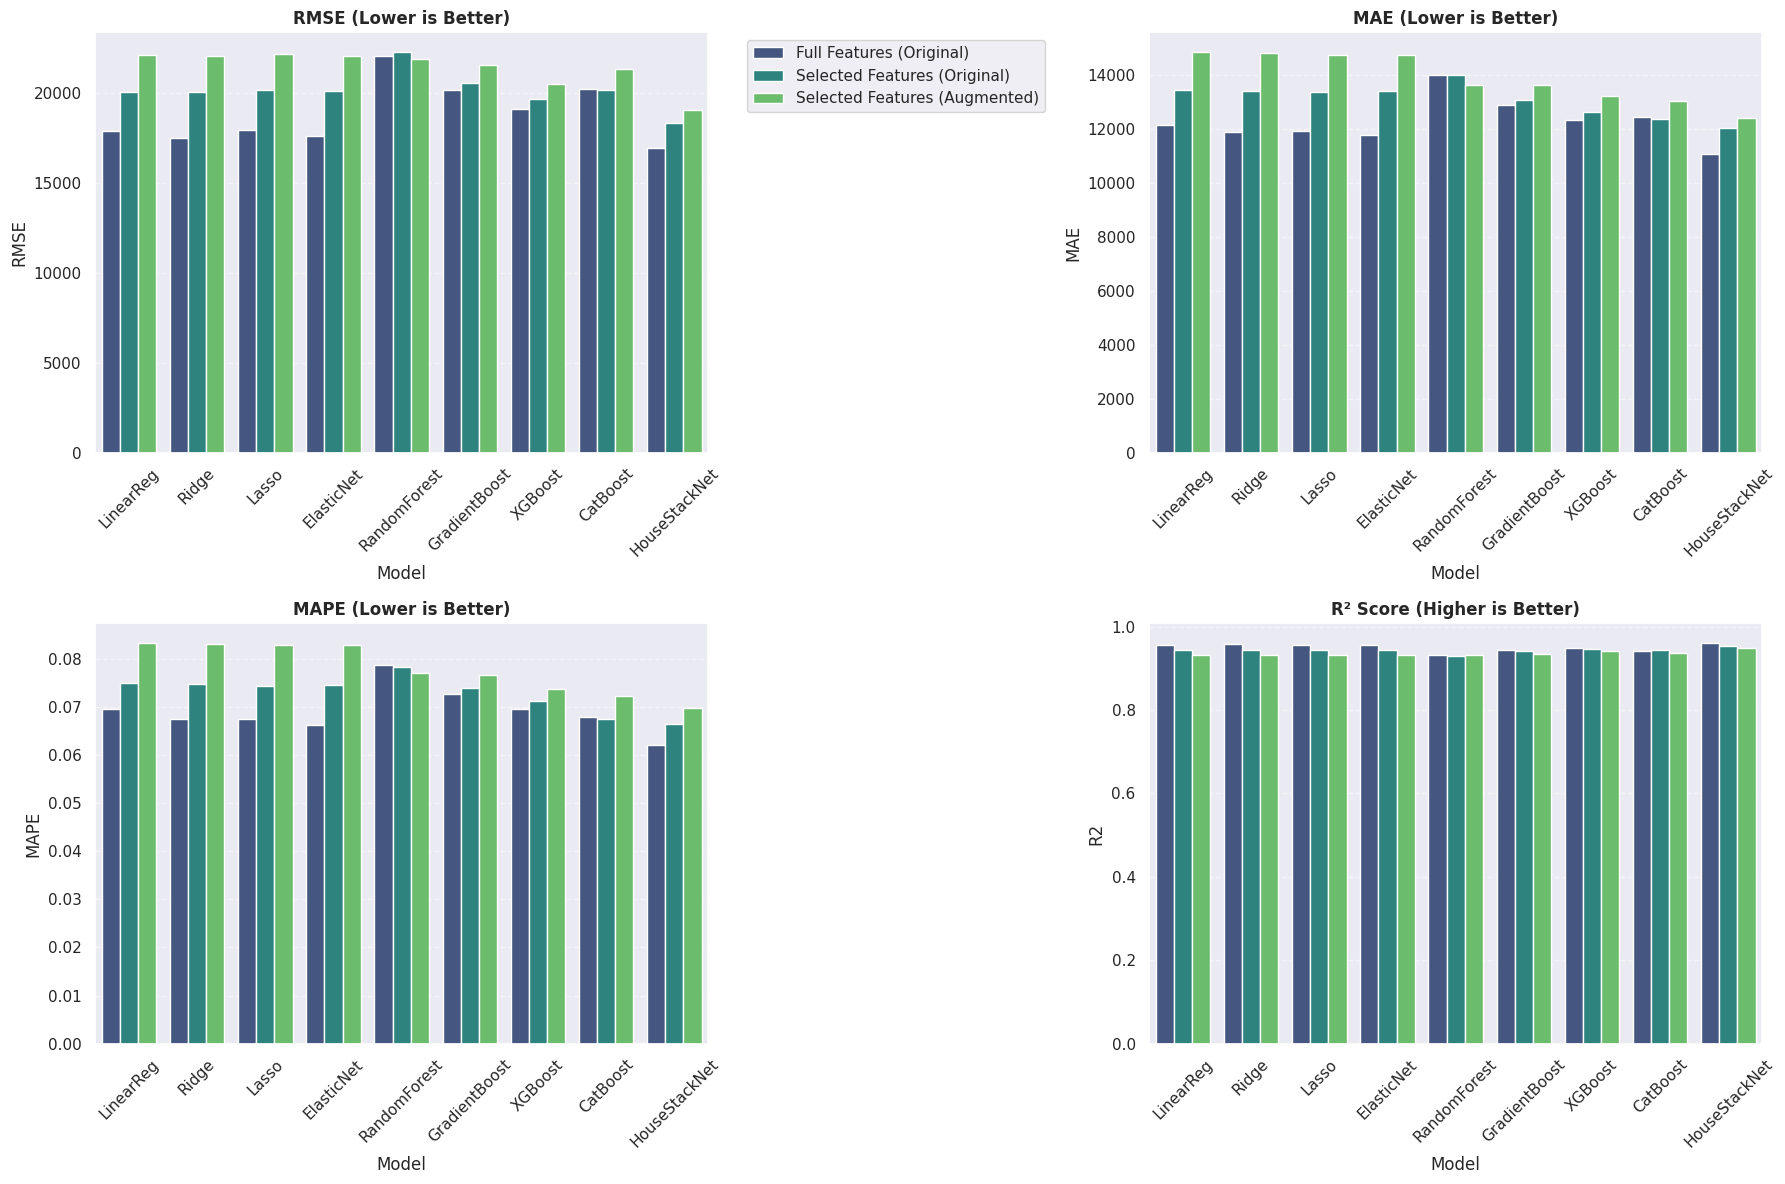

In [11]:
# === PHASE 9: FINAL RESULTS COMPARISON (CORRECTED) ===
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print("FINAL RESULTS COMPARISON (ALL SCENARIOS)")
print("="*80)

# 1. Combine ALL scenario results
final_df = pd.concat([results_sk1, results_sk2, results_sk3_total], ignore_index=True)

# 2. Deduplicate
# Skenario 1 (Full) and Skenario 3 (Original Full) are identical for base models.
# We keep Skenario 3 versions because they include HouseStackNet.
# We remove 'Skenario 1' duplicates to avoid confusion in the table.
# But we keep 'Skenario 2' because it's distinct (SHAP only).
df_clean_comparison = final_df[final_df['Scenario'].isin([
    'Skenario 3 (Original Full)',
    'Skenario 3 (Original SHAP)',
    'Skenario 3 (Augmented SHAP)'
])].copy()

# Rename for cleanliness
df_clean_comparison['Scenario'] = df_clean_comparison['Scenario'].replace({
    'Skenario 3 (Original Full)': 'Full Features (Original)',
    'Skenario 3 (Original SHAP)': 'Selected Features (Original)',
    'Skenario 3 (Augmented SHAP)': 'Selected Features (Augmented)'
})

# List of metrics to analyze
metrics = ['RMSE', 'MAE', 'MAPE', 'R2']

# 3. Print Pivot Tables
for metric in metrics:
    print(f"\n📊 DETAILED ANALYSIS: {metric}")

    pivot = df_clean_comparison.pivot(index='Model', columns='Scenario', values=metric)

    # Calculate Impact of Feature Selection (Full vs Selected)
    if 'Full Features (Original)' in pivot.columns and 'Selected Features (Original)' in pivot.columns:
        pivot['Impact: Selection'] = pivot['Selected Features (Original)'] - pivot['Full Features (Original)']

    # Calculate Impact of Augmentation
    if 'Selected Features (Augmented)' in pivot.columns and 'Selected Features (Original)' in pivot.columns:
        pivot['Impact: Augmentation'] = pivot['Selected Features (Augmented)'] - pivot['Selected Features (Original)']

    # Formatting
    if metric == 'R2':
        fmt = '{:.4f}'
        cmap = 'RdYlGn'
    elif metric == 'MAPE':
        fmt = '{:.2%}'
        cmap = 'RdYlGn_r'
    else:
        fmt = '{:,.0f}'
        cmap = 'RdYlGn_r'

    display(pivot.style.format(fmt).background_gradient(cmap=cmap))

# 4. Visualization
print("\n" + "="*80)
print("VISUALIZATION DASHBOARD")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

titles = {
    'RMSE': 'RMSE (Lower is Better)',
    'MAE':  'MAE (Lower is Better)',
    'MAPE': 'MAPE (Lower is Better)',
    'R2':   'R² Score (Higher is Better)'
}

for i, metric in enumerate(metrics):
    sns.barplot(
        data=df_clean_comparison,
        x='Model',
        y=metric,
        hue='Scenario',
        palette='viridis',
        ax=axes[i]
    )
    axes[i].set_title(titles[metric], fontsize=12, fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

    if i == 0:
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        axes[i].get_legend().remove()

plt.tight_layout()
plt.show()

### Kesimpulan Eksperimen Augmentasi

**Hasil Observasi**
Berdasarkan evaluasi perbandingan, penggunaan data sintetik (*Augmented Data*) memberikan dampak **negatif atau tidak signifikan** terhadap performa model. Hal ini kemungkinan disebabkan oleh distribusi data sintetik (TVAE) yang gagal merepresentasikan kompleksitas harga rumah asli, sehingga menambah *noise*.

>  **KEPUTUSAN:**
>
> Demi menjaga validitas dan akurasi prediksi, analisis selanjutnya (*Explainability*) dan kesimpulan akhir penelitian ini akan didasarkan sepenuhnya pada model yang dilatih menggunakan **ORIGINAL DATASET**.

In [12]:
# === PHASE 10: KEPUTUSAN AKHIR (FINAL DECISION) ===
from IPython.display import display

print("\n" + "="*80)
print("KEPUTUSAN AKHIR (FINAL DECISION)")
print("="*80)

# 1. Prepare Data
# Remove Augmented scenarios for final decision
clean_df = final_df[~final_df['Scenario'].str.contains("Augmented")].copy()

# Rename scenarios for cleaner table (Matches your image format)
clean_df['Scenario'] = clean_df['Scenario'].replace({
    'Skenario 1': 'Sk 1 (All Feat)',
    'Skenario 2': 'Sk 2 (SHAP Feat)',
    'Skenario 3 (Original Full)': 'Sk 3 (Stacking Base)',
    'Skenario 3 (Original SHAP)': 'Sk 3 (Stacking SHAP)'
})

# 2. CREATE "CHAMPIONS TABLE" (Best Scenario per Model)
champions = clean_df.loc[clean_df.groupby('Model')['RMSE'].idxmin()].sort_values(by='RMSE').reset_index(drop=True)
champions.index += 1

# 3. CREATE FULL SORTED TABLE
full_ranked = clean_df.sort_values(by='RMSE').reset_index(drop=True)
full_ranked.index += 1

# --- DISPLAY TABLES ---

print("🏆 TABEL 5: PERFORMA TERBAIK PER MODEL")
display(
    champions[['Model', 'Scenario', 'RMSE', 'MAE', 'MAPE', 'R2']].style
    .format({'RMSE': '{:,.0f}', 'MAE': '{:,.0f}', 'MAPE': '{:.2%}', 'R2': '{:.4f}'})
    .background_gradient(subset=['RMSE', 'MAE', 'MAPE'], cmap='RdYlGn_r')
    .background_gradient(subset=['R2'], cmap='RdYlGn')
)

print("\n📋 DETAILED: ALL ORIGINAL SCENARIOS RANKED")
display(
    full_ranked[['Model', 'Scenario', 'RMSE', 'MAE', 'MAPE', 'R2']].style
    .format({'RMSE': '{:,.0f}', 'MAE': '{:,.0f}', 'MAPE': '{:.2%}', 'R2': '{:.4f}'})
    .background_gradient(subset=['RMSE', 'MAE', 'MAPE'], cmap='RdYlGn_r')
    .background_gradient(subset=['R2'], cmap='RdYlGn')
)

# 4. Identify Overall Winner
winner = champions.iloc[0]
best_model_name = winner['Model']
best_scenario_name = winner['Scenario']
best_rmse = winner['RMSE']

# 5. Analysis Logic
is_linear_winner = any(x in best_model_name for x in ['Ridge', 'Lasso', 'Elastic', 'Linear'])
is_stacking_winner = 'HouseStackNet' in best_model_name

print(f"""
KEPUTUSAN:
Kita akan menggunakan **{best_model_name} ({best_scenario_name})** sebagai model final untuk tahap Explainability.
""")

# 6. Set Context for Phase 11
# Re-map clean names back to variable names
if "All Feat" in best_scenario_name or "Stacking Base" in best_scenario_name:
    X_explain = X_train_sk1
    X_test_explain = X_test_sk1
    print(f"\n[INFO] Setting Context: Using FULL FEATURES ({X_explain.shape[1]} cols)")
else:
    X_explain = X_train_sel
    X_test_explain = X_test_sel
    print(f"\n[INFO] Setting Context: Using SHAP SELECTED FEATURES ({X_explain.shape[1]} cols)")

y_explain = y_train


KEPUTUSAN AKHIR (FINAL DECISION)
🏆 TABEL 5: PERFORMA TERBAIK PER MODEL


,Model,Scenario,RMSE,MAE,MAPE,R2
1,HouseStackNet,Sk 3 (Stacking Base),"16,928","11,090",6.22%,0.9597
2,Ridge,Sk 1 (All Feat),"17,486","11,888",6.74%,0.9570
3,ElasticNet,Sk 1 (All Feat),"17,622","11,767",6.62%,0.9563
4,LinearReg,Sk 1 (All Feat),"17,863","12,141",6.94%,0.9551
5,Lasso,Sk 1 (All Feat),"17,917","11,940",6.74%,0.9548
6,XGBoost,Sk 1 (All Feat),"19,111","12,322",6.96%,0.9486
7,GradientBoost,Sk 1 (All Feat),"20,125","12,896",7.26%,0.9430
8,CatBoost,Sk 2 (SHAP Feat),"20,177","12,365",6.74%,0.9427
9,RandomForest,Sk 3 (Stacking Base),"22,056","13,996",7.87%,0.9316



📋 DETAILED: ALL ORIGINAL SCENARIOS RANKED


,Model,Scenario,RMSE,MAE,MAPE,R2
1,HouseStackNet,Sk 3 (Stacking Base),"16,928","11,090",6.22%,0.9597
2,Ridge,Sk 1 (All Feat),"17,486","11,888",6.74%,0.9570
3,Ridge,Sk 3 (Stacking Base),"17,486","11,888",6.74%,0.9570
4,ElasticNet,Sk 1 (All Feat),"17,622","11,767",6.62%,0.9563
5,ElasticNet,Sk 3 (Stacking Base),"17,622","11,767",6.62%,0.9563
6,LinearReg,Sk 3 (Stacking Base),"17,863","12,141",6.94%,0.9551
7,LinearReg,Sk 1 (All Feat),"17,863","12,141",6.94%,0.9551
8,Lasso,Sk 1 (All Feat),"17,917","11,940",6.74%,0.9548
9,Lasso,Sk 3 (Stacking Base),"17,917","11,940",6.74%,0.9548
10,HouseStackNet,Sk 3 (Stacking SHAP),"18,324","12,024",6.65%,0.9528



KEPUTUSAN:
Kita akan menggunakan **HouseStackNet (Sk 3 (Stacking Base))** sebagai model final untuk tahap Explainability.


[INFO] Setting Context: Using FULL FEATURES (273 cols)



[Phase 11] Analyzing Feature Impact using HouseStackNet...
           Data Context: FULL FEATURES (273 cols)
    1. Calculating Feature Ranking...
    Top 5 Features Identified: ['Overall Qual', 'TotalSF', 'Central Air_N', 'TotalBath', 'Kitchen Qual']


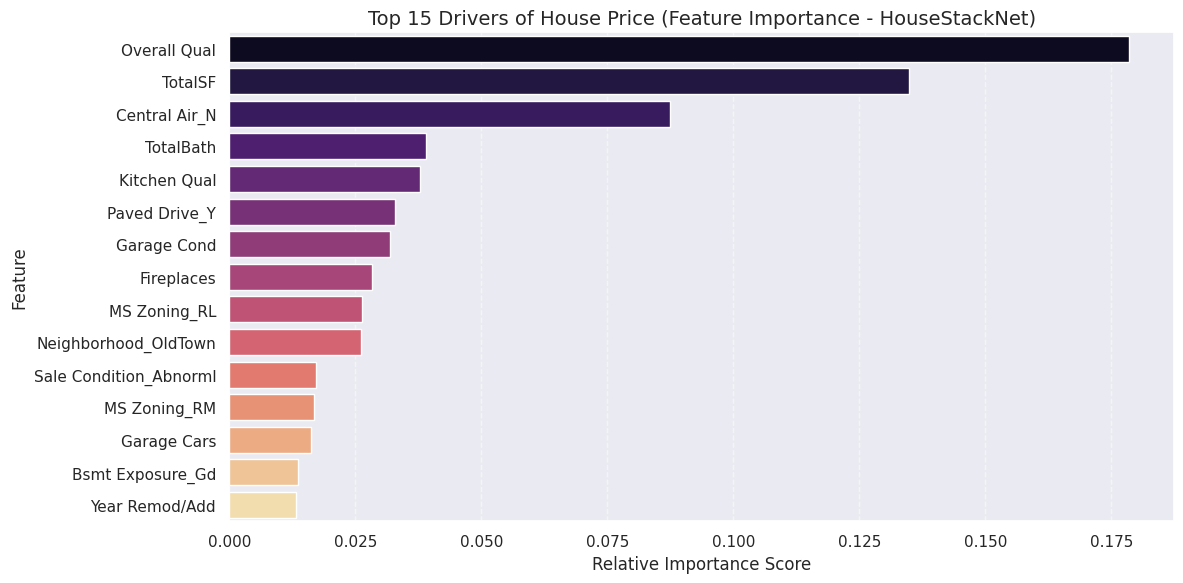


REVISION 2: QUANTIFYING FEATURE IMPACT (DAMPAK REAL)


,Fitur,Koefisien (Log),Est. Dampak Harga,Interpretasi,Arah
0,Overall Qual,0.2075,"$-127,506.66",Setiap kenaikan 1 Level Kualitas,Meningkatkan
1,TotalSF,0.2072,"$-127,552.35",Setiap penambahan luas 1 Satuan (sqft),Meningkatkan
2,Central Air_N,-0.2213,"$-198,613.43",Setiap penambahan 1 Unit,Menurunkan
3,TotalBath,0.0690,"$-153,880.67",Setiap penambahan 1 Unit,Meningkatkan
4,Kitchen Qual,0.0797,"$-151,970.74",Setiap kenaikan 1 Level Kualitas,Meningkatkan


Catatan: 'Est. Dampak Harga' adalah estimasi perubahan harga rata-rata jika fitur tersebut bertambah 1 unit.

    3. Visualizing Impact with SHAP Dependence Plots...


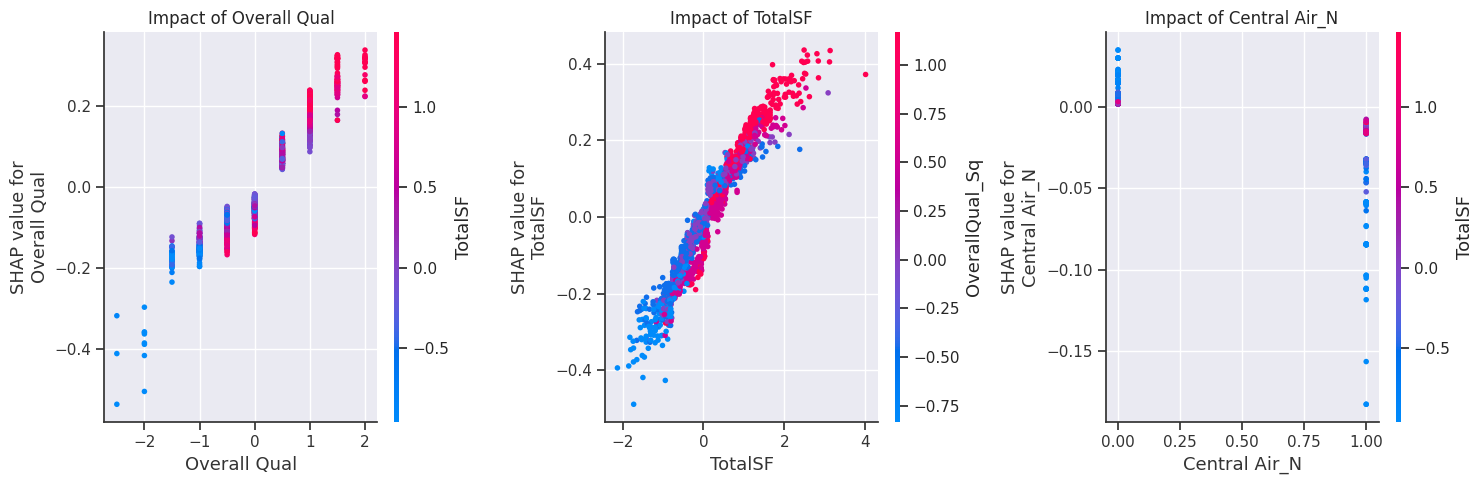


    4. Validating Model Predictions...


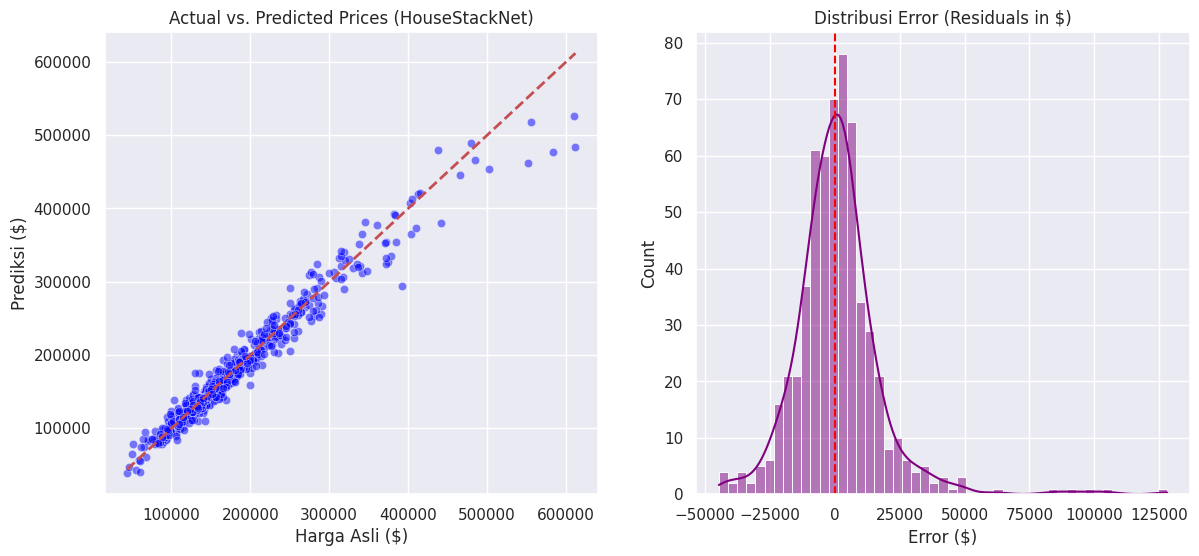

In [13]:
# === PHASE 11: EXPLAINABILITY & FEATURE IMPACT (FIXED) ===

# 1. Setup Data based on Phase 10 Decision
if isinstance(best_model_name, pd.Series):
    best_model_str = best_model_name.item()
else:
    best_model_str = str(best_model_name)

print(f"\n[Phase 11] Analyzing Feature Impact using {best_model_str}...", flush=True)

# Determine Context (Full vs Selected)
if X_explain.shape[1] == X_train_sk1.shape[1]:
    print(f"           Data Context: FULL FEATURES ({X_explain.shape[1]} cols)")
    X_test_explain = X_test_sk1
else:
    print(f"           Data Context: SELECTED FEATURES ({X_explain.shape[1]} cols)")
    X_test_explain = X_test_sel

import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# 1. FEATURE IMPORTANCE (Ranking)
# ---------------------------------------------------------
print("    1. Calculating Feature Ranking...", flush=True)

# Use Tree Model as Proxy for importance ranking
if "CatBoost" in best_model_str:
    explainer_model = CatBoostRegressor(iterations=100, depth=6, verbose=0, random_state=42)
else:
    # XGBoost is standard proxy (even for Stack/Linear models)
    explainer_model = XGBRegressor(n_estimators=100, max_depth=4, random_state=42)

explainer_model.fit(X_explain, y_train)

if "CatBoost" in best_model_str:
    importances = explainer_model.get_feature_importance()
else:
    importances = explainer_model.feature_importances_

# Get Top Features
imp_df = pd.DataFrame({
    'Feature': X_explain.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top_10_features = imp_df.head(10)['Feature'].tolist()
top_5_features = top_10_features[:5]
print(f"    Top 5 Features Identified: {top_5_features}")

# --- ADDED BAR PLOT HERE ---
plt.figure(figsize=(12, 6))
sns.barplot(data=imp_df.head(15), x='Importance', y='Feature', palette='magma')
plt.title(f"Top 15 Drivers of House Price (Feature Importance - {best_model_str})", fontsize=14)
plt.xlabel("Relative Importance Score")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 2. FEATURE IMPACT ANALYSIS (Konversi Log ke Dollar)
# ---------------------------------------------------------
print("\n" + "="*60)
print("REVISION 2: QUANTIFYING FEATURE IMPACT (DAMPAK REAL)")
print("="*60)

# Train Linear Regression untuk mendapatkan koefisien arah (+/-)
impact_model = LinearRegression()
impact_model.fit(X_explain[top_5_features], y_train)

# Hitung Rata-rata Harga Asli (Un-log) untuk basis perhitungan
mean_price_real = np.expm1(y_train.mean())

impact_results = []
for feature, coef in zip(top_5_features, impact_model.coef_):
    # KONVERSI LOG KE DOLLAR:
    dollar_impact = mean_price_real * (np.expm1(coef) - 1)

    if "Qual" in feature: desc = "Setiap kenaikan 1 Level Kualitas"
    elif "SF" in feature or "Area" in feature: desc = "Setiap penambahan luas 1 Satuan (sqft)"
    elif "Year" in feature: desc = "Setiap rumah lebih muda 1 Tahun"
    else: desc = "Setiap penambahan 1 Unit"

    impact_results.append({
        'Fitur': feature,
        'Koefisien (Log)': f"{coef:.4f}",
        'Est. Dampak Harga': f"${dollar_impact:,.2f}",
        'Interpretasi': desc,
        'Arah': "Meningkatkan" if coef > 0 else "Menurunkan"
    })

impact_df = pd.DataFrame(impact_results)
display(impact_df)
print("Catatan: 'Est. Dampak Harga' adalah estimasi perubahan harga rata-rata jika fitur tersebut bertambah 1 unit.")

# ---------------------------------------------------------
# 3. SHAP DEPENDENCE PLOTS
# ---------------------------------------------------------
print("\n    3. Visualizing Impact with SHAP Dependence Plots...")
explainer = shap.TreeExplainer(explainer_model)
shap_values = explainer.shap_values(X_explain)

plt.figure(figsize=(15, 5))
for i, feature in enumerate(top_5_features[:3]):
    plt.subplot(1, 3, i+1)
    shap.dependence_plot(feature, shap_values, X_explain, ax=plt.gca(), show=False)
    plt.title(f"Impact of {feature}")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 4. RESIDUAL ANALYSIS
# ---------------------------------------------------------
print("\n    4. Validating Model Predictions...")

# Re-train best model for plotting
if "CatBoost" in best_model_str:
    final_model = CatBoostRegressor(iterations=600, depth=6, verbose=0, random_state=42)
elif "XGBoost" in best_model_str:
    final_model = XGBRegressor(n_estimators=500, max_depth=3, random_state=42)
elif "RandomForest" in best_model_str:
    final_model = RandomForestRegressor(n_estimators=300, min_samples_leaf=2, random_state=42)
elif "HouseStackNet" in best_model_str:
    # Use Ridge meta for stability if stack won
    final_model = HouseStackNet(meta_learner_type='ridge')
elif "Ridge" in best_model_str:
    final_model = Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=10.0))])
else:
    # Fallback
    final_model = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])

# Train on the CORRECT dataset
final_model.fit(X_explain, y_train)

y_pred_log = final_model.predict(X_test_explain)

# Invert Log for plotting
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred_log)
residuals = y_test_real - y_pred_real

plt.figure(figsize=(14, 6))

# Actual vs Predicted
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_real, y=y_pred_real, alpha=0.5, color='blue')
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--', linewidth=2)
plt.title(f'Actual vs. Predicted Prices ({best_model_str})')
plt.xlabel('Harga Asli ($)')
plt.ylabel('Prediksi ($)')

# Residual Dist
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='purple')
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribusi Error (Residuals in $)')
plt.xlabel('Error ($)')
plt.show()